In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import glob
import os

In [14]:
df = pd.read_csv('../data/archive/occupation_shares.csv')
df = df.iloc[:-1]
df.iloc[:, 1:] = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce').fillna(0)
df = df.set_index('MET2013')

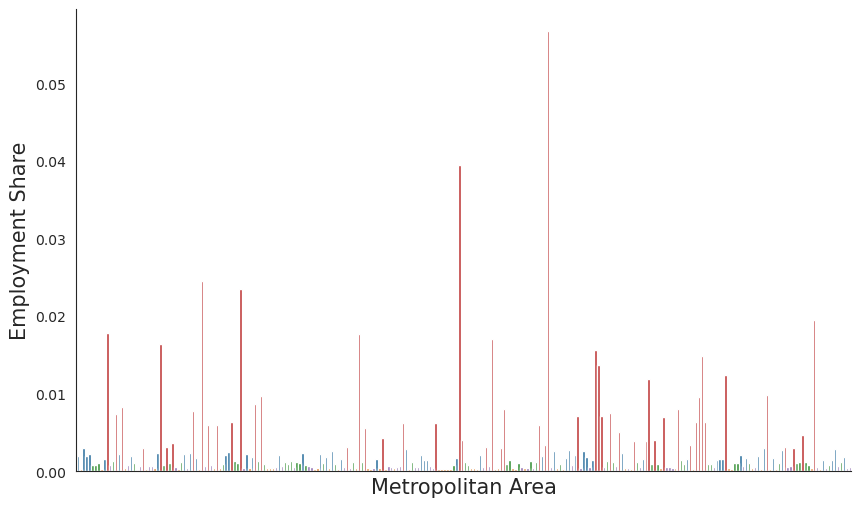

In [15]:
df['index'] = range(len(df))

# Define the colors for the quintiles
colors = ['blue', 'green', 'yellow', 'orange', 'red']

# Divide the 'city_total' column into quintiles
quintiles = pd.qcut(df['city_total'].iloc[1:], 5, labels=False)

# Map each quintile to a color
df['color'] = quintiles.map(lambda x: colors[x])

plt.figure(figsize=(10, 6))  # Increase the figure size
sns.set_style("white")  # Set the style of the plot to 'white'
barplot = sns.barplot(x='index', y='city_total', data=df.iloc[1:], hue='color', dodge=False)  # Use the colors
barplot.legend_.remove()  # Remove the legend
# plt.title('Metropolitan Area Employment Share by Total Employment', fontsize=20)  # Add a title and increase the font size
plt.xlabel('Metropolitan Area', fontsize=15)  # Increase the font size of the x-label
plt.ylabel('Employment Share', fontsize=15)  # Increase the font size of the y-label
plt.xticks([])  # Remove x-axis labels
sns.despine()  # Remove the box around the plot
plt.savefig('graphs/city_employment_share.png')
plt.show()

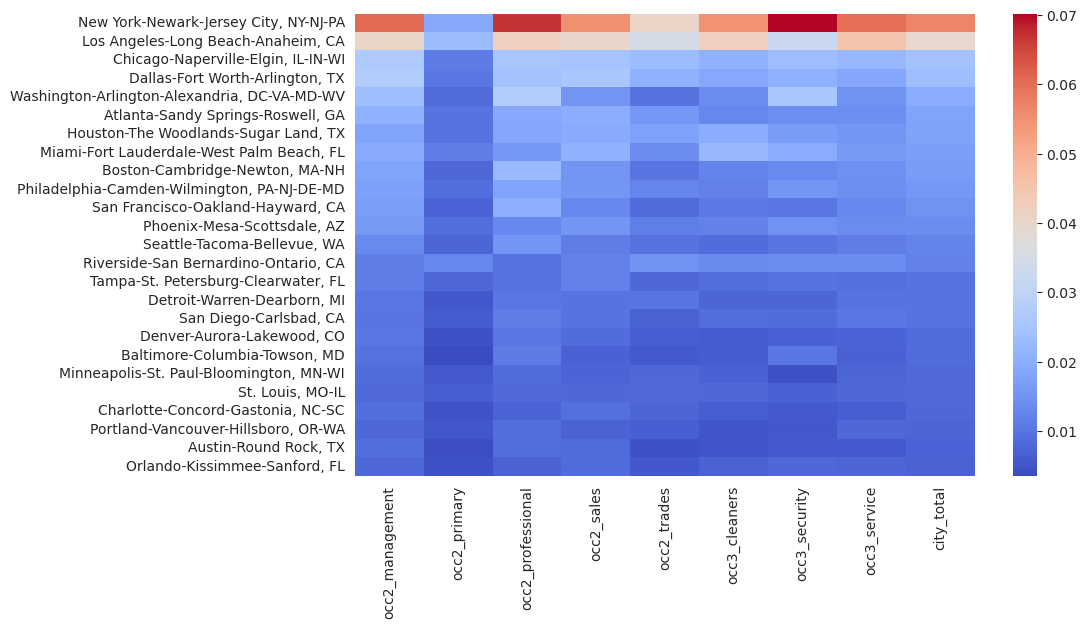

In [16]:
df = df.drop(columns=['index', 'color'])

# Sort the DataFrame by 'city_total' in descending order and select the top 25 rows
df_top25 = df.iloc[1:].sort_values('city_total', ascending=False).head(25)

plt.figure(figsize=(10, 6))  # Increase the figure size
sns.heatmap(df_top25, annot=False, cmap='coolwarm', cbar_kws={'label': ''})  # Create a heatmap without a colorbar label
# plt.title('Top 25 Metropolitan Areas by Occupation', fontsize=20)  # Add a title and increase the font size
plt.xlabel('')  # Remove the x-label
plt.ylabel('')  # Remove the y-label
plt.savefig('graphs/top_25_occupation_heatmap.png')
plt.show()

In [17]:
df = pd.read_csv('../data/archive/met_occupation.csv')
df.set_index('MET2013', inplace=True)
df = df.iloc[1:]
df.iloc[:, 1:] = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce').fillna(0)
df.iloc[-1].name = 'Occupation Total'
df = df.div(df.iloc[:, -1], axis=0)


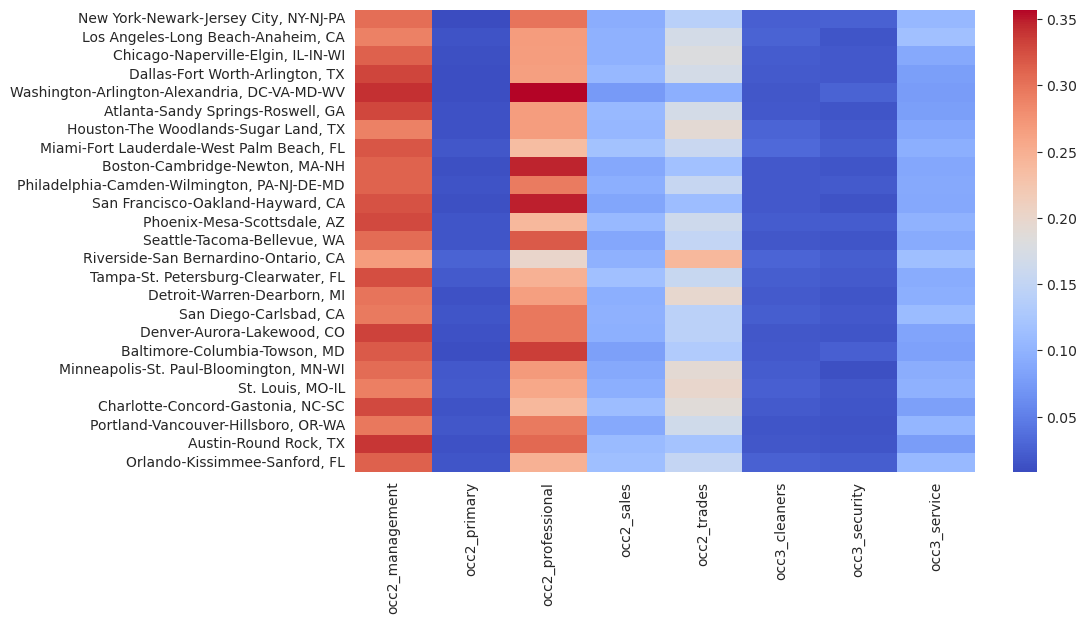

In [18]:
cities = df_top25.index.to_list()

df_top25 = df.loc[cities]
df_top25 = df_top25.drop(columns=['city_total'])

plt.figure(figsize=(10, 6))  # Increase the figure size
sns.heatmap(df_top25, annot=False, cmap='coolwarm', cbar_kws={'label': ''})  # Create a heatmap without a colorbar label
# plt.title('Occupation Shares of Top 25 Metropolitan Areas', fontsize=20)  # Add a title and increase the font size
plt.xlabel('')  # Remove the x-label
plt.ylabel('')  # Remove the y-label
plt.savefig('graphs/top_25_city_heatmap.png')
plt.show()

In [19]:
files = glob.glob('../data/processed/city_occ_employment/*.csv')

final = pd.DataFrame()

for file in files:
    year = int(os.path.basename(file)[-8:-4])
    current = pd.read_csv(file)
    current['city_total'] = current.iloc[:, 1:].sum(axis=1)
    current = current.melt(id_vars=['MET2013'], var_name='Occupation', value_name='Employed')
    current['Year'] = year
    final = pd.concat([final, current], ignore_index=True)

occupation_year_total = final.groupby(['Year', 'Occupation'])['Employed'].sum().reset_index(name='Total_Employed')
final = pd.merge(final, occupation_year_total, on=['Year', 'Occupation'])
final['Shares'] = final['Employed'] / final['Total_Employed']
final = final.drop(columns=['Total_Employed'])
final = final[final['MET2013'] != 'Not in identifiable area']

final = final[['Year', 'MET2013', 'Occupation', 'Shares', 'Employed']]

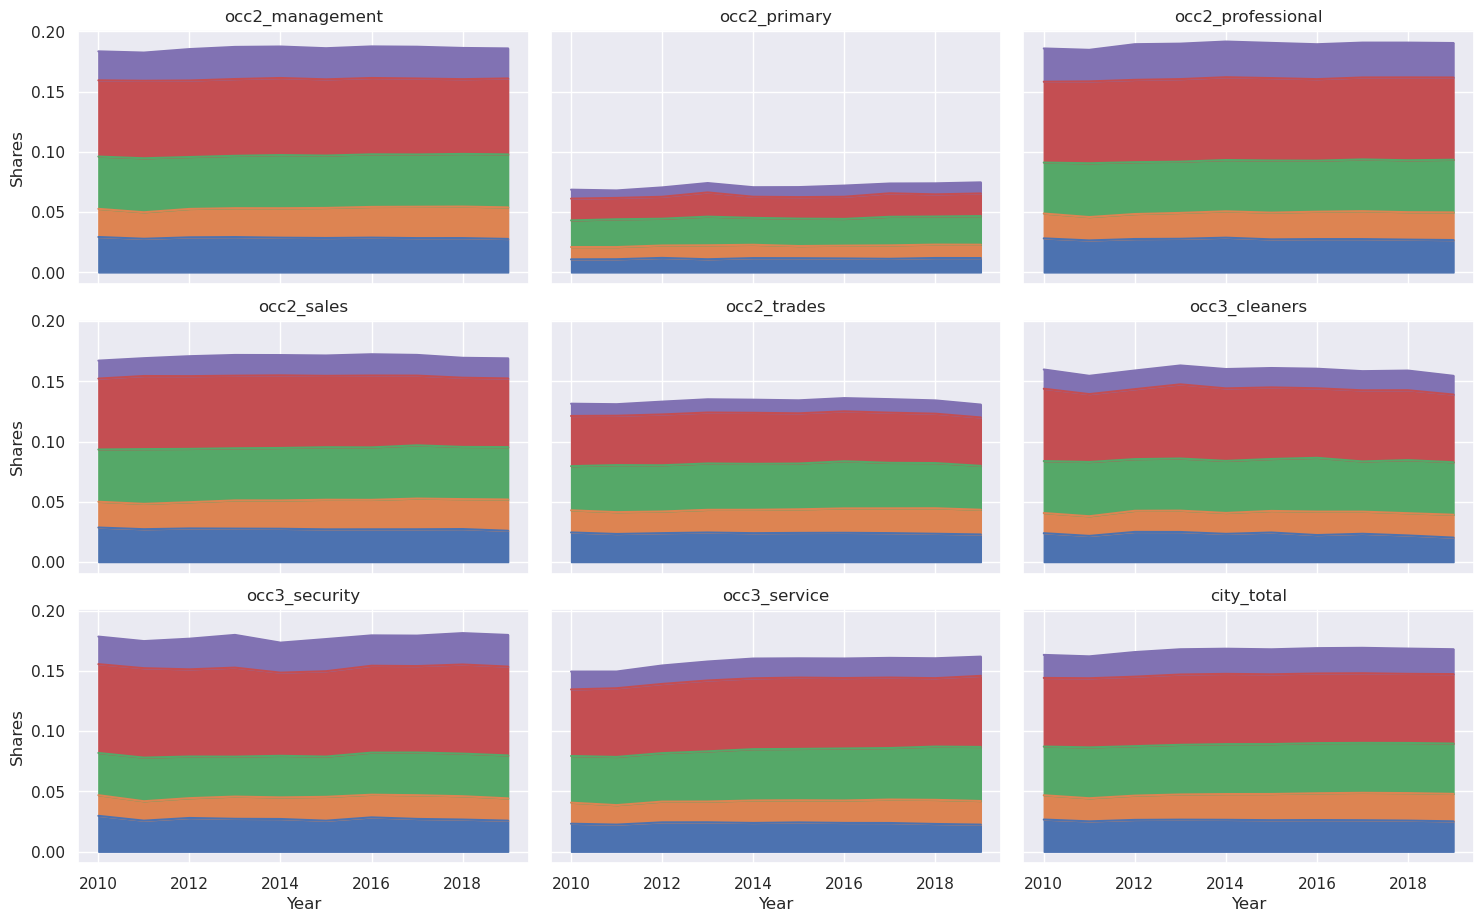

In [20]:
# Unique occupations
occupations = final['Occupation'].unique()

top_city = final[final['Year'] == 2010]
top_city = final.groupby(['Occupation', 'MET2013'])['Shares'].sum().groupby(level=0, group_keys=False).nlargest(6).reset_index()
top_city = top_city['MET2013'].unique()
top_city = top_city[0:5]
top = final[final['MET2013'].isin(top_city)]

sns.set_theme()

# Assuming there are exactly 9 occupations for simplicity
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10), sharex=True, sharey=True)
# fig.suptitle('Shares of Top 5 Cities Over Time for Each Occupation (2010-2019)', fontsize=20)

# Flatten axes for easy iteration
axes = axes.flatten()

for i, occupation in enumerate(occupations):
    # Pivot data for current occupation
    pivot_df = top[top['Occupation'] == occupation].pivot_table(index='Year', columns='MET2013', values='Shares', aggfunc='sum')
    
    # Plot in the ith subplot
    pivot_df.plot.area(stacked=True, ax=axes[i], title=occupation, legend=False)
    axes[i].set_title(occupation)
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Shares')

# Adjust layout
plt.tight_layout()
# Adjust the main title so it doesn't overlap with subplots
plt.subplots_adjust(top=0.9)
plt.savefig('graphs/city_occ_ot.png')
plt.show()

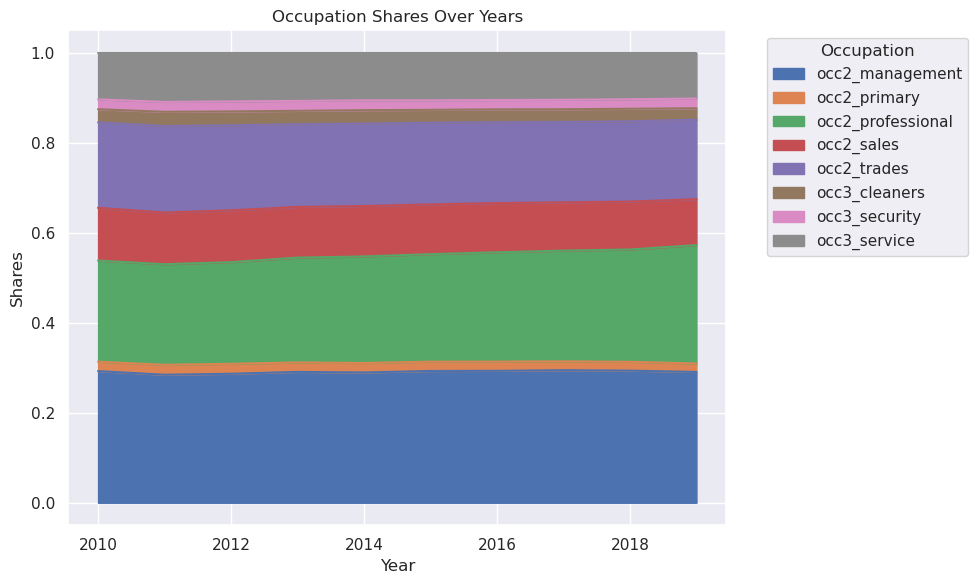

In [21]:
occ_shares = final.groupby(['Year', 'Occupation'])['Employed'].sum().reset_index()
occ_shares = occ_shares[occ_shares['Occupation'] != 'city_total']
total = occ_shares.groupby('Year')['Employed'].sum().reset_index(name='Total_Employed')
occ_shares = pd.merge(occ_shares, total, on='Year')
occ_shares['Shares'] = occ_shares['Employed'] / occ_shares['Total_Employed']
occ_shares = occ_shares.drop(columns=['Total_Employed'])

# Pivot the DataFrame to get years as index, occupations as columns, and shares as values
pivot_df = occ_shares.pivot(index='Year', columns='Occupation', values='Shares')

# Plotting the stacked area graph
pivot_df.plot.area(stacked=True, figsize=(10, 6))
plt.title('Occupation Shares Over Years')
plt.xlabel('Year')
plt.ylabel('Shares')
plt.legend(title='Occupation', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('graphs/occ_share_ot.png')
plt.show()

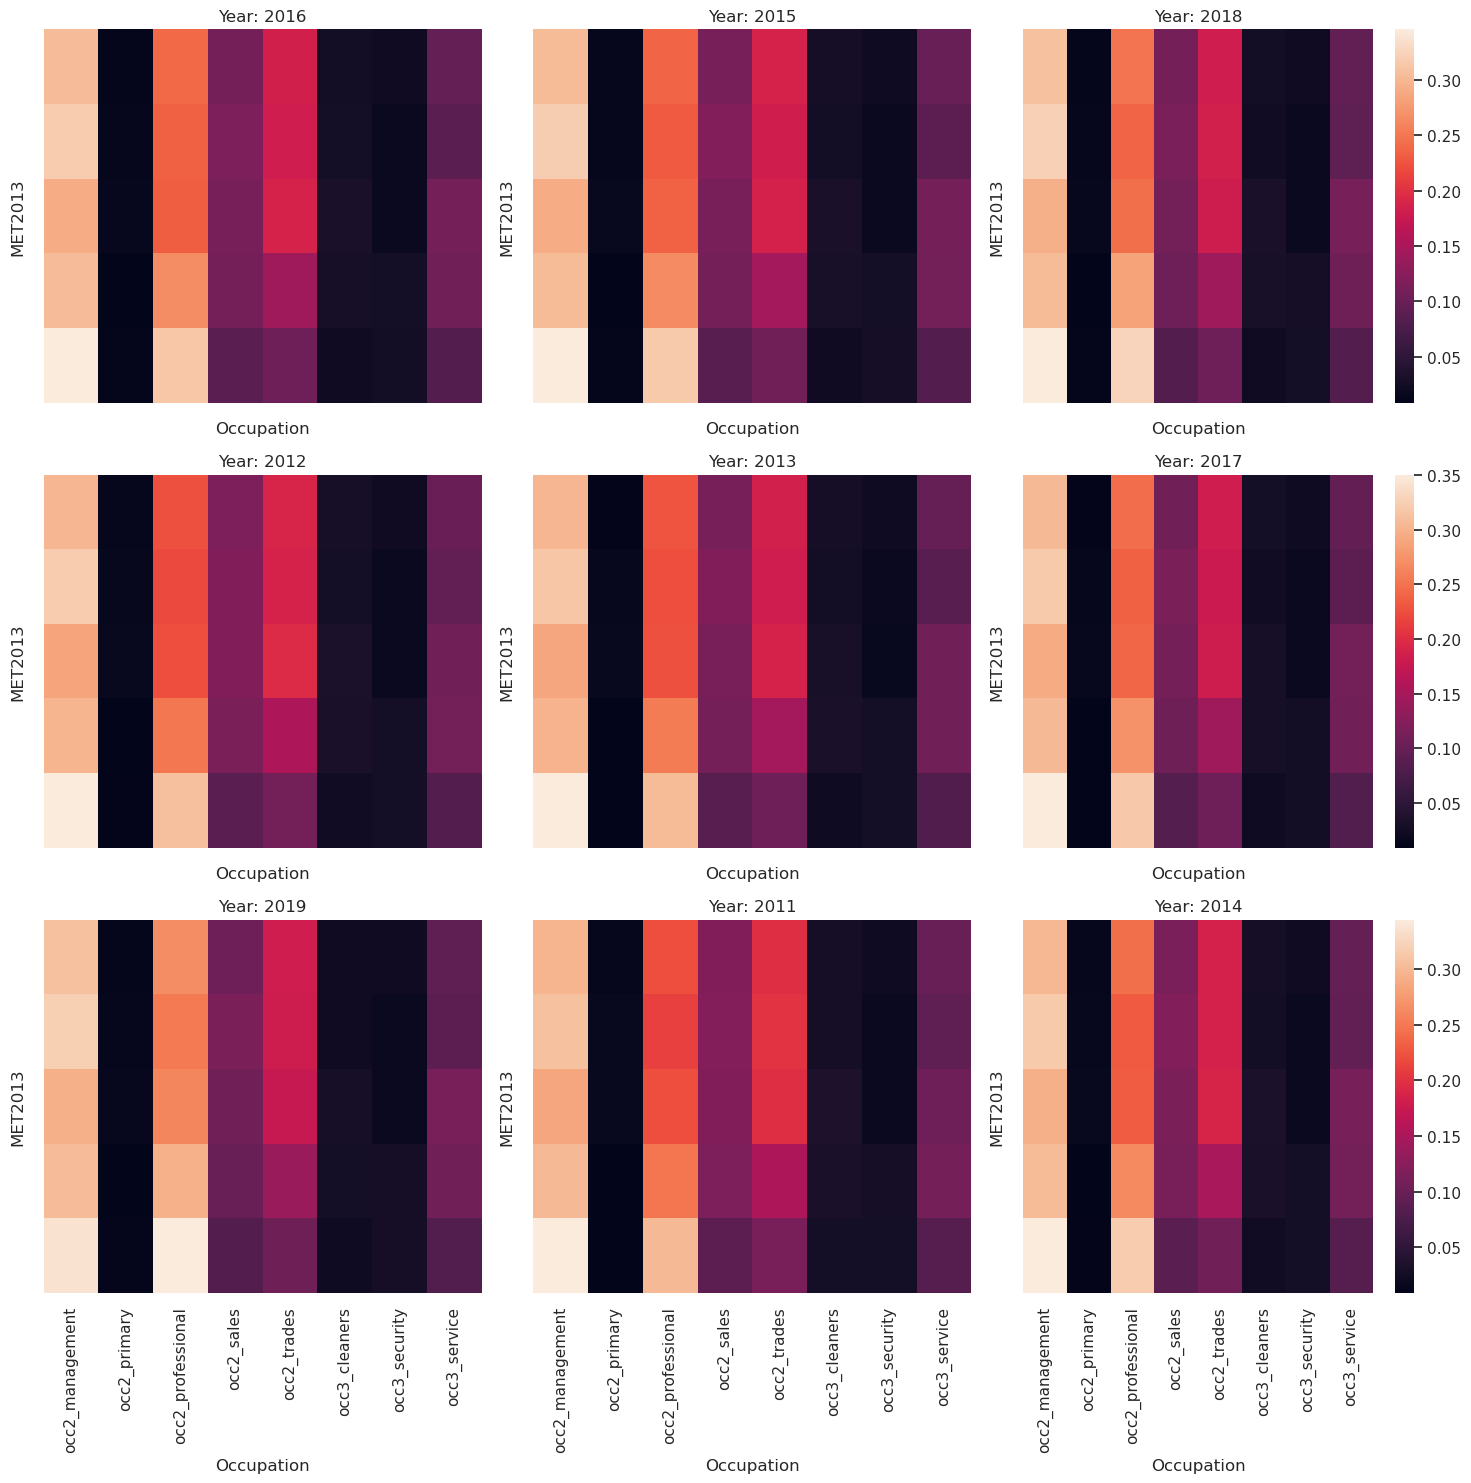

In [24]:
current = final.copy()
current = current.drop(columns=['Shares'])
current = current[current['Occupation'] != 'city_total']
occupation_year_total = current.groupby(['Year', 'MET2013'])['Employed'].sum().reset_index(name='Total_Employed')
current = pd.merge(current, occupation_year_total, on=['Year', 'MET2013'])
current['Shares'] = current['Employed'] / current['Total_Employed']
current = current.drop(columns=['Total_Employed'])

# Step 2: Filter the data for these top 5 cities
top_cities_data = current[current['MET2013'].isin(top_city)]

years = top_cities_data['Year'].unique()

# Prepare the figure for a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()  # Flatten the 3x3 matrix of axes to easily iterate over it

for i, year in enumerate(years[:9]):  # Limit to the first 9 years if there are more
    # Filter the data for the current year and top 5 cities
    year_data = current[(current['MET2013'].isin(top_city)) & (current['Year'] == year)]
    
    # Pivot the data for the heatmap
    pivot_table = year_data.pivot(index='MET2013', columns='Occupation', values='Shares')
    
    # Plot the heatmap in the ith subplot
    sns.heatmap(pivot_table, ax=axes[i], cbar=(i + 1) % 3 == 0, annot=False)  # Show color bar only for the first plot
    axes[i].set_title(f"Year: {year}")
    axes[i].set_yticklabels([])

    if i < 6:
        axes[i].set_xticklabels([])

plt.tight_layout()
plt.savefig('graphs/occ_city_ot.png')
plt.show()